# Stage 0 Load Datasets

In [2]:
import pandas as pd 
df_train = pd.read_csv('../Data/df_18800_train.csv')
df_syn = pd.read_csv('../Data/df_18800_train_TabDDPM_defaultTransformer_300_1_0.csv')
df_holdout = pd.read_csv('../Data/df_18800_holdout.csv')
df_val = pd.read_csv('../Data/df_18800_val.csv')
print("data is loaded...") # 0.3 s

data is loaded...


In [3]:
from Dataset_Utility import utility_functions as uf
uf.calculate_label_rate(df_train)
uf.calculate_label_rate(df_syn)
uf.calculate_label_rate(df_holdout)
uf.calculate_label_rate(df_val)

Total Sample size is 5367, Positive Sample size is 159, Negative Sample size is 5208, label rate is 0.03
Total Sample size is 5367, Positive Sample size is 207, Negative Sample size is 5160, label rate is 0.04
Total Sample size is 5367, Positive Sample size is 159, Negative Sample size is 5208, label rate is 0.03
Total Sample size is 2684, Positive Sample size is 80, Negative Sample size is 2604, label rate is 0.03


# Stage 1 Train 4 Models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

# 創建一個字典來存儲你想要訓練的模型
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

In [5]:
# 假設你的目標變量列名叫 'label'
X_train = df_train.drop('label', axis=1)  # 訓練集特徵數據
y_train = df_train['label']  # 訓練集目標數據

X_val = df_val.drop('label', axis=1)  # 驗證集特徵數據
y_val = df_val['label']  # 驗證集目標數據

In [6]:
# 迴圈遍歷模型字典
for name, model in models.items():
    # 訓練模型
    model.fit(X_train, y_train)
    # 在驗證數據集上預測
    val_predictions = model.predict(X_val)
    # 計算驗證集的準確度
    val_accuracy = accuracy_score(y_val, val_predictions)
    print(f'{name} Validation Accuracy: {val_accuracy:.2f}')

Logistic Regression Validation Accuracy: 0.97
Decision Tree Validation Accuracy: 0.95
Random Forest Validation Accuracy: 0.97
SVM Validation Accuracy: 0.97


# Stage 2 More refined performance metric

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# 假設你的目標變量列名叫 'label'
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']

X_val = df_val.drop('label', axis=1)
y_val = df_val['label']

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)  # 確保SVM可以輸出概率
}

# 初始化一個DataFrame來存儲結果
results = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'AUC', 'TPR', 'FPR', 'TNR', 'FNR'])

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]  # 獲得正類別的預測概率

    # 計算準確度和AUC
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    # 計算混淆矩陣並抽取TP, FN, FP, TN
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    # 計算性能指標
    tpr = tp / (tp + fn)  # 真陽性率
    fpr = fp / (fp + tn)  # 假陽性率
    tnr = tn / (tn + fp)  # 真陰性率
    fnr = fn / (tp + fn)  # 假陰性率

    # 固定小數點後三位並儲存結果
    results.loc[name] = [
        round(accuracy, 3), round(auc, 3),
        round(tpr, 3), round(fpr, 3), round(tnr, 3), round(fnr, 3)
    ]

print(results)

                    Accuracy    AUC    TPR    FPR    TNR    FNR
Logistic Regression     0.97  0.728    0.0    0.0    1.0    1.0
Decision Tree          0.954  0.595    0.2  0.023  0.977    0.8
Random Forest          0.967  0.733  0.125  0.007  0.993  0.875
SVM                     0.97   0.57    0.0    0.0    1.0    1.0


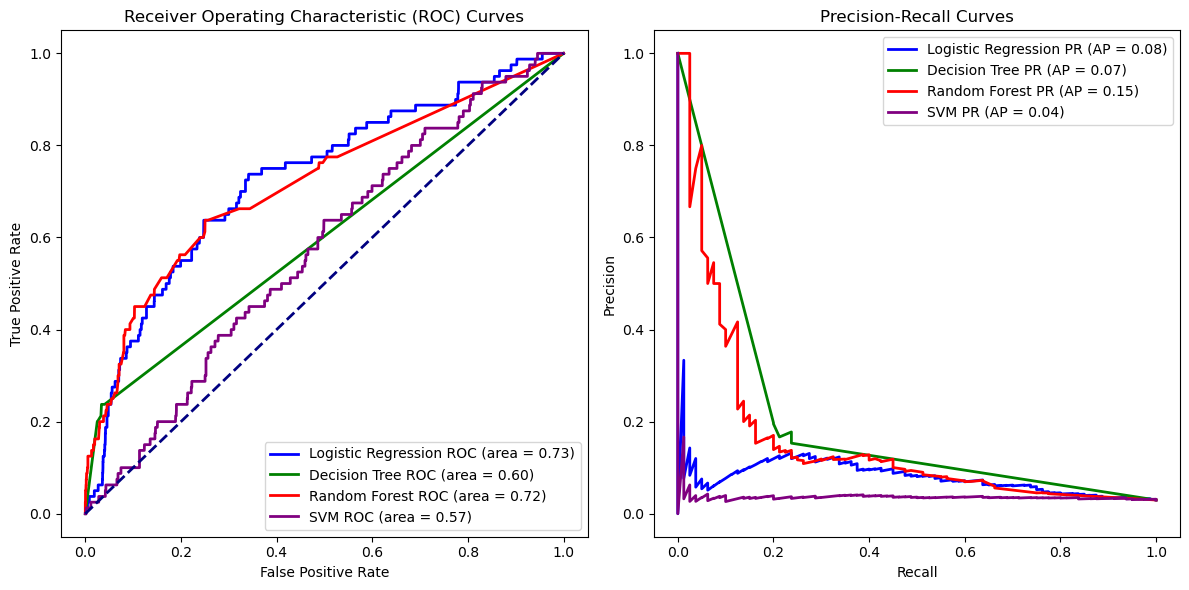

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 設定圖片尺寸和布局
plt.figure(figsize=(12, 6))

# 第一個subplot為ROC曲線
plt.subplot(1, 2, 1)
colors = ['blue', 'green', 'red', 'purple']  # 每個模型一個顏色
model_index = 0

for name, model in models.items():
    # 獲得預測結果及概率
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # 計算ROC曲線及AUC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    # 繪製ROC曲線
    plt.plot(fpr, tpr, color=colors[model_index], lw=2, label=f'{name} ROC (area = {roc_auc:.2f})')
    model_index += 1

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# 第二個subplot為Precision-Recall曲線
plt.subplot(1, 2, 2)
colors = ['blue', 'green', 'red', 'purple']  # 重設顏色索引
model_index = 0

for name, model in models.items():
    y_proba = model.predict_proba(X_val)[:, 1]

    # 計算Precision-Recall曲線及AP
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    ap = average_precision_score(y_val, y_proba)

    # 繪製Precision-Recall曲線
    plt.plot(recall, precision, color=colors[model_index], lw=2, label=f'{name} PR (AP = {ap:.2f})')
    model_index += 1

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()